# ShapeFit examples

In this notebook we will show how to perform ShapeFit fits to data power spectrum, using Taylor expansion to speed up likelihood evaluation.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 31)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
fo = cosmo.get_fourier()
pk = fo.pk_interpolator(of='delta_cb')(k, z=z)
b = 2.
f = fo.sigma8_z(z, of='theta_cb') / fo.sigma8_z(z, of='delta_cb')
shotnoise = 1 / 5e-4
volume = 1e10

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1000):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)
data, mocks = mocks[0], mocks[1:]

## ShapeFit likelihood

In [2]:
from desilike.theories.galaxy_clustering import ShapeFitPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.parameter import Parameter, ParameterPrior
from desilike import setup_logging


template = ShapeFitPowerSpectrumTemplate(z=z, fiducial='DESI')
template.params['dm'].update(ref={'limits': [-0.001, 0.001]})
template.params['f'].update(ref={'limits': [0.85, 0.88]})
for name in ['qpar', 'qper']: template.params[name].update(ref={'limits': [0.998, 1.002]})
theory = KaiserTracerPowerSpectrumMultipoles(template=template)
theory.params['b1'].update(value=2.)
observable = TracerPowerSpectrumMultipolesObservable(data=data, mocks=mocks,
                                                     klim={0: [0.02, 0.2], 2: [0.02, 0.2]}, # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])



# NOTE: if we wanted to fit xi instead:
# theory = KaiserTracerCorrelationFunctionMultipoles(template=template)
# observable = TracerCorrelationFunctionObservable(data=data, mocks=mocks,
#                                                  slim={0: [40., 160], 2: [40., 160]}, # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
#                                                  theory=theory)
# The rest would be the same

setup_logging()
likelihood()  # just to initialize

[000000.13] [0/1] 01-13 20:00  ObservablesGaussianLikelihood INFO     Covariance matrix with 36 points built from 999 observations.
[000000.13] [0/1] 01-13 20:00  ObservablesGaussianLikelihood INFO     ...resulting in Hartlap factor of 0.9629.


/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/cosmoprimo-1.0.0-py3.9.egg/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000001.04] [0/1] 01-13 20:00  absl                      INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000001.04] [0/1] 01-13 20:00  absl                      INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000001.04] [0/1] 01-13 20:00  absl                      INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000001.04] [0/1] 01-13 20:00  absl                      INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000001.04] [0/1] 01-13 20:00  absl                      WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


DeviceArray(-2607.65077421, dtype=float64)

[000001.42] [0/1] 01-13 20:00  Emulator                  INFO     Varied parameters: ['qpar', 'qper', 'dm', 'f', 'b1', 'sn0'].
[000001.42] [0/1] 01-13 20:00  Emulator                  INFO     Found varying ['f_sqrt_Ap', 'm', 'power'] and fixed ['Ap', 'n', 'k', 'ells'] outputs.
[000001.42] [0/1] 01-13 20:00  Differentiation           INFO     Varied parameters: ['qpar', 'qper', 'dm', 'f', 'b1', 'sn0'].
[000001.53] [0/1] 01-13 20:00  Differentiation           INFO     Using finite-differentiation for parameter qpar.
[000001.55] [0/1] 01-13 20:00  Differentiation           INFO     Using finite-differentiation for parameter qper.
[000001.58] [0/1] 01-13 20:00  Differentiation           INFO     Using finite-differentiation for parameter dm.
[000002.21] [0/1] 01-13 20:00  Differentiation           INFO     Using auto-differentiation for parameter f.
[000002.28] [0/1] 01-13 20:00  Differentiation           INFO     Using auto-differentiation for parameter b1.
[000002.33] [0/1] 01-13 20:00 

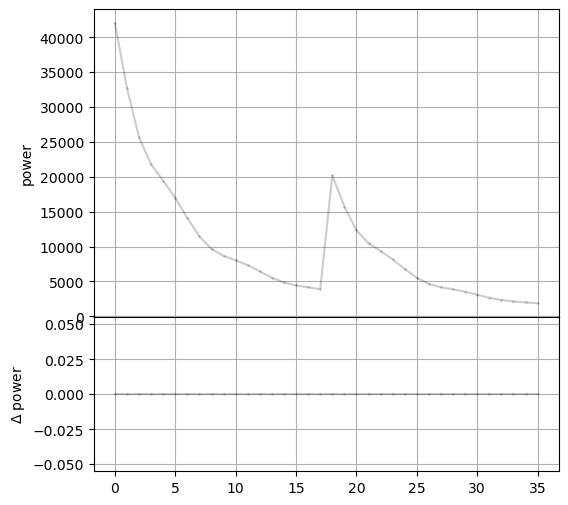

In [3]:
from desilike.emulators import Emulator, EmulatedCalculator, TaylorEmulatorEngine

emulator = Emulator(theory, engine=TaylorEmulatorEngine(order={'*': 2, 'sn0': 1}))  # order 2 except for sn0 (order 1 is enough)
emulator.set_samples()
emulator.fit()
emulator.plot(name='power')

import os
base_dir = '_tests'
kaiser_emulator_fn = os.path.join(base_dir, 'kaiser_emulator.npy')
emulator.save(kaiser_emulator_fn)

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [4]:
from desilike.samplers import ZeusSampler

# Let's just update the observable's theory, no need to redefine the observable & likelihood
# (Internally the code will reinitialize all calculators that depend on observable)
observable.init.update(theory=emulator.to_calculator())

sampler = ZeusSampler(likelihood, save_fn='_tests/chain_fs_shapefit_*.npy', seed=42)
sampler.run(check={'max_eigen_gr': 0.1})

[000004.92] [0/1] 01-13 20:00  ObservablesGaussianLikelihood INFO     Covariance matrix with 36 points built from 999 observations.
[000004.92] [0/1] 01-13 20:00  ObservablesGaussianLikelihood INFO     ...resulting in Hartlap factor of 0.9629.
[000004.93] [0/1] 01-13 20:00  ZeusSampler               INFO     Varied parameters: ['qpar', 'qper', 'dm', 'f', 'b1', 'sn0'].
[000005.34] [0/1] 01-13 20:00  root                      INFO     Initialising ensemble of 16 walkers...
[000281.93] [0/1] 01-13 20:05  Chain                     INFO     Saving _tests/chain_fs_shapefit_0.npy.
[000281.94] [0/1] 01-13 20:05  ZeusSampler               INFO     Diagnostics:
[000281.95] [0/1] 01-13 20:05  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.118; not < 0.1.
[000281.96] [0/1] 01-13 20:05  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0201.
[000281.99] [0/1] 01-13 20:05  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.126.
[

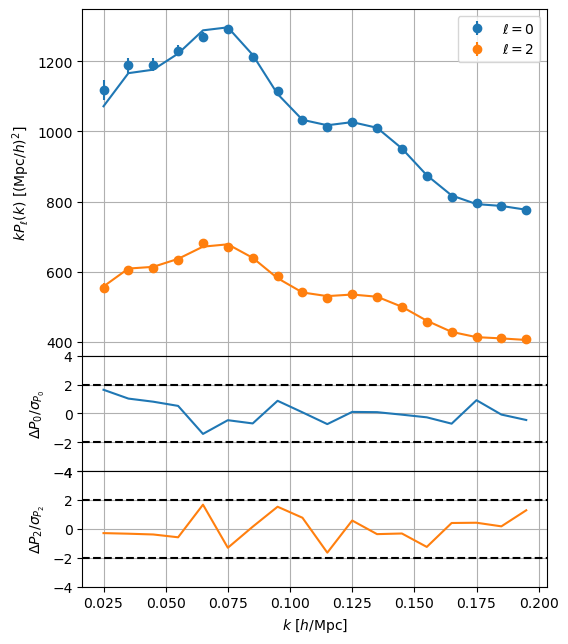

In [5]:
likelihood(**sampler.chains[0].choice(params=likelihood.varied_params))
observable.plot()
plt.show()

In [6]:
chain = sampler.chains[0].remove_burnin(0.5)
print(chain.to_stats(tablefmt='pretty'))

+------+---------+---------+---------+--------+-----------------+-----------------+
|      | argmax  |  mean   | median  |  std   | quantile:1sigma | interval:1sigma |
+------+---------+---------+---------+--------+-----------------+-----------------+
| qpar | 0.9998  | 1.0002  | 1.0002  | 0.0026 | -0.0027/+0.0026 | -0.0026/+0.0026 |
| qper | 0.9947  | 0.9941  | 0.9940  | 0.0048 | -0.0046/+0.0048 | -0.0047/+0.0047 |
|  dm  | -0.0020 | -0.0011 | -0.0009 | 0.0061 | -0.0060/+0.0060 | -0.0061/+0.0059 |
|  f   | 0.8735  | 0.8708  | 0.8708  | 0.0053 | -0.0054/+0.0055 | -0.0062/+0.0046 |
|  b1  | 1.9995  | 2.0015  | 2.0015  | 0.0094 | -0.0095/+0.0096 | -0.0100/+0.0091 |
| sn0  |   30.   |   23    |   24    |  30.   |    -30./+30.    |     -29/+31     |
+------+---------+---------+---------+--------+-----------------+-----------------+


[001117.91] [0/1] 01-13 20:19  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in
[001119.34] [0/1] 01-13 20:19  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[001119.34] [0/1] 01-13 20:19  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


[001121.16] [0/1] 01-13 20:19  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[001121.16] [0/1] 01-13 20:19  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


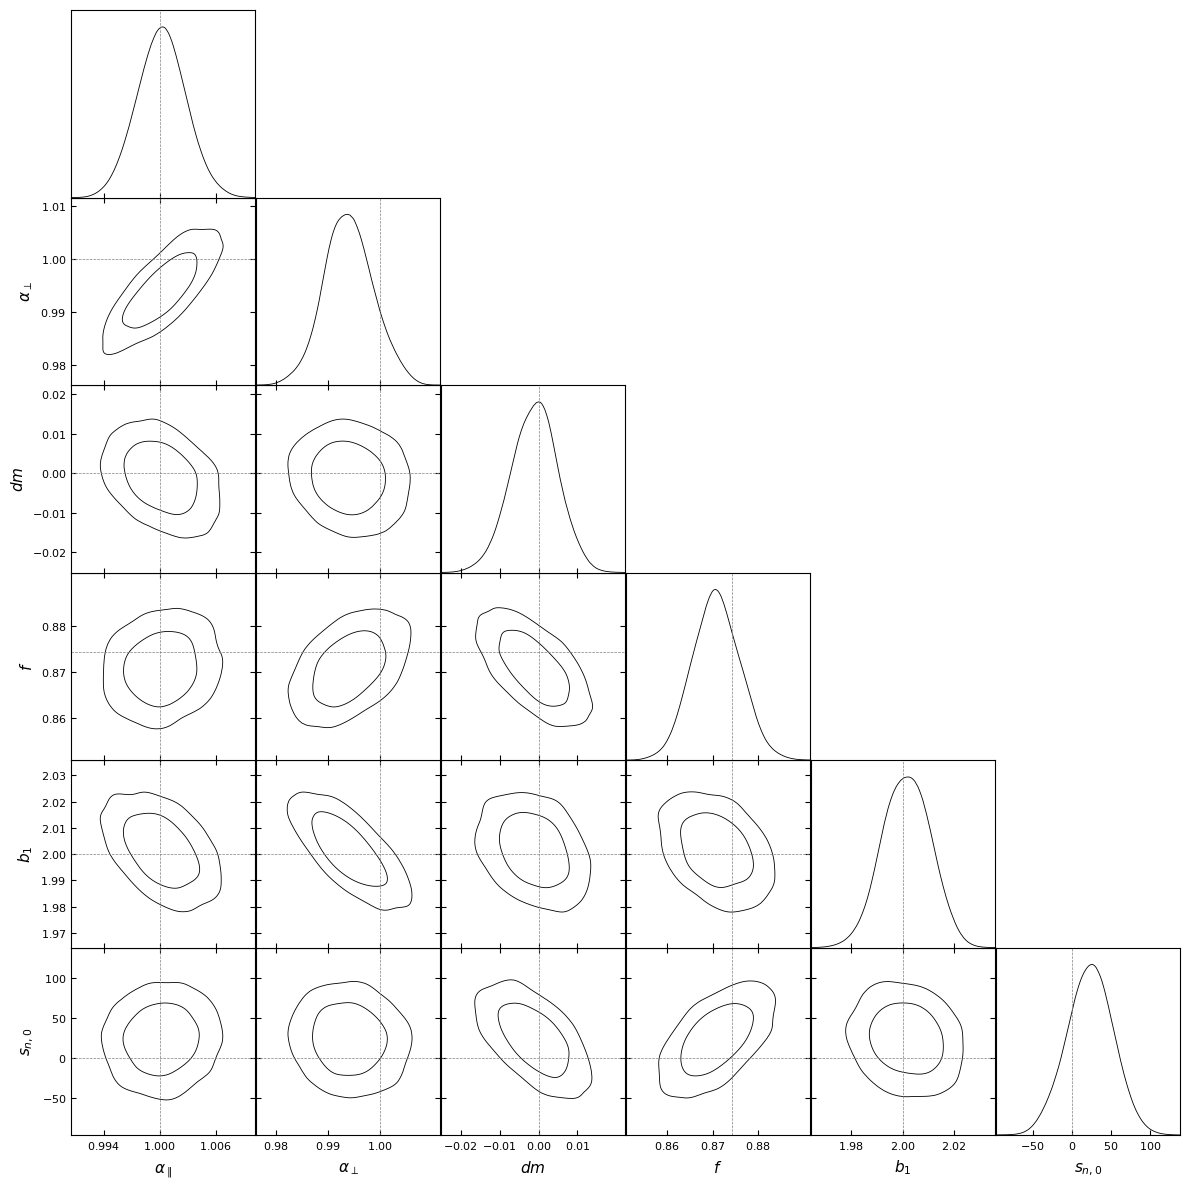

In [7]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'qpar': 1., 'qper': 1., 'f': f, 'dm': 0., 'b1': b, 'sn0': 0.})